## News summation
### 뉴스 요약봇 만들기
***
#### Step 1. 데이터 수집하기

    1. 뉴스 기사 데이터 가져오기  

#### Step 2. 데이터 전처리하기 (추상적 요약) 

    -실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 
     추가 사용하여 텍스트를 정규화 또는 정제해 보세요.  
     
    -만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 
     불용어를 제거하는 것이 좋을지 고민해보세요.  

#### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
    일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 
    더 나은 성능을 얻을 수 있어요.  
    
    실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

#### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
    원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.  
    
#### Step 5. Summa을 이용해서 추출적 요약해보기
***
#### 평가문항  
**1. 추상적(Abstractive) 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.**  
-분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
  
**2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.**  
-모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
  
**3. 추출적(Extractive) 요약을 시도해 보고 추상적(Abstractive) 요약 결과과 함께 비교해 보았다.**  
-두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.
***
### Step 1. 데이터 수집하기

In [1]:
# 필요한 라이브러리 import
import os
from os.path import join
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer


**1. 뉴스 기사 데이터 가져오기**

In [2]:
# 노드를 진행하면서 다운받은 뉴스 요약 data 가져오기
# https://github.com/sunnysai12345/News_Summary
data_dir = os.getenv('HOME')+'/aiffel/news_summarization/data'
data_path = join(data_dir, 'news_summary_more.csv')
data = pd.read_csv(data_path, encoding='iso-8859-1')
data.head(5)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


### Step 2. 데이터 전처리하기 (추상적 요약)
    -실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 
     추가 사용하여 텍스트를 정규화 또는 정제해 보세요.  
    -만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 
     불용어를 제거하는 것이 좋을지 고민해보세요.  
***
**1. 중복 샘플 제거**   

중복 샘플을 제거하기전 전체 샘플의 수를 확인해봅니다.

In [3]:
print('전체 샘플수 :',len(data))

전체 샘플수 : 98401


한 칼럼당 98401개의 데이터가 있는것을 확인할 수 있습니다.

In [4]:
for c in data.columns:
    print('{}열의 unique : {}'.format(c, data[c].nunique()))

headlines열의 unique : 98280
text열의 unique : 98360


유니크한 데이터의 갯수를 확인해보니 두개의 칼럼 모두 전체 샘플수와 차이가 나는것을 확인할 수 있습니다.  
이러한 중복 샘플을 제거해 주도록 하겠습니다.

In [5]:
for c in data.columns:
    data.drop_duplicates(subset = [c], inplace = True)

데이터프레임의 drop_duplicates()를 사용하여 중복 샘플을 지워줍니다.

In [6]:
print('전체 샘플수 :',len(data))

전체 샘플수 : 98262


기존의 샘플수와 비교해보았을 때 중복 샘플이 제거 된 것을 확인할 수 있습니다.
***
**2. 결측 샘플 제거**  

Null값을 가지는 데이터 샘플을 확인해봅니다.

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


.isnull().sum()로 확인해본 결과 다행히 결측치는 없는 것으로 확인되었습니다.  
참고로 Null값 제거에는 dropna() 함수를 사용하면 됩니다.
***   
**3. 텍스트 정규화 및 불용어 제거**  

i'am, it'll 등 줄여진 표현들을 정리하여 연산량을 줄이도록 하겠습니다.

In [8]:
# 노드에서 사용하였던 정규화 사전을 이용하도록 하겠습니다.
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

In [9]:
# 텍스트 소문자화 => 섞여있을 수 있는 ltml태그 제거 => 특수문자 제거 => 정규화 => 불용어 제거
# 위의 과정을 위한 함수 생성
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

이제 함수를 활용하여 text칼럼과 headline칼럼을 정리해주도록 하겠습니다.

In [10]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))
    
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [11]:
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))
    # 요약이므로 불용어를 제외할 경우 문장 자체가 이상해질 수 있음.

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

두 칼럼에서 불용어를 모두 정리를 완료했으니 해당칼럼을 교체해주도록 합니다.

In [12]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 불용어를 제거하면서 빈 값이 생겼을 수도 있으니
# 빈 값을 Null 값으로 변환합니다.
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

다행히 빈 샘플이 없습니다.  
이제 샘플 문장의 최대길이를 설정하겠습니다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
텍스트의 표준 편차 : 3.7996134352887116
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299444342675704
헤드라인의 표준 편차 : 1.3899968497820723


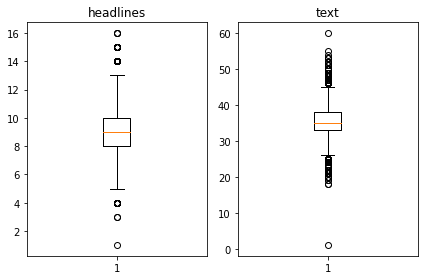

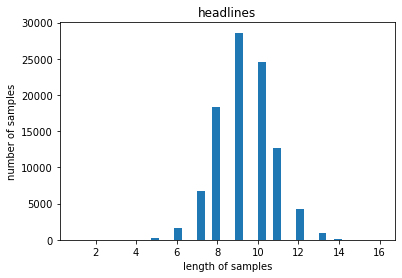

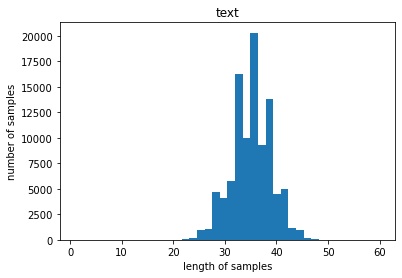

In [13]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트의 표준 편차 : {}'.format(np.std(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('헤드라인의 표준 편차 : {}'.format(np.std(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

생각보다 데이터가 고르게 분포되어있습니다.  
각 칼럼 샘플의 최대길이는 (평균+(2x표준편차로)) 결정하겠습니다.

In [14]:
text_maxlen = int((np.mean(text_len)+(2*np.std(text_len))))
headlines_maxlen = int((np.mean(headlines_len)+(2*np.std(headlines_len))))

In [15]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_maxlen)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_maxlen)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 94658


In [16]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [17]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [18]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 18931


In [19]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 75727
훈련 레이블의 개수 : 75727
테스트 데이터의 개수 : 18931
테스트 레이블의 개수 : 18931


In [20]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [21]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67890
등장 빈도가 6번 이하인 희귀 단어의 수: 46262
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21628
단어 집합에서 희귀 단어의 비율: 68.14258359110326
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5646182891543363


In [22]:
src_vocab = 21000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 21,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [23]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1338, 249, 1, 196, 160, 273, 210, 289, 319, 20, 780, 940, 2575, 4, 1338, 1, 10, 871, 393, 272, 439, 515], [11, 107, 388, 207, 206, 68, 2036, 304, 1132, 336, 9573, 114, 429, 781, 92, 2, 640, 351, 3, 13, 3127, 310, 12209, 1097, 68, 987, 304, 1132, 427, 189, 207, 337, 192, 559, 562, 917, 6611, 6012, 756, 1752, 351, 114], [3659, 327, 311, 4879, 12591, 20211, 209, 3571, 811, 382, 4758, 115, 4191, 2809, 3226, 20211, 651, 1, 5777, 2809, 646, 12592, 2408, 3416, 811, 980, 693, 2565, 6368]]


In [24]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [25]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29544
등장 빈도가 5번 이하인 희귀 단어의 수: 19313
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10231
단어 집합에서 희귀 단어의 비율: 65.37029515299216
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.772538489771476


In [26]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 470, 77, 153, 76, 17, 148, 10, 702, 590], [1, 105, 5277, 815, 1992, 253, 720, 7040, 205, 4, 863], [1, 3011, 4, 82, 5075, 1788, 7, 1696, 6, 2550, 5076], [1, 1143, 3, 21, 1646, 56, 12, 6030, 741, 56, 2129], [1, 4, 4406, 201, 61, 3, 2281, 1789, 4407]]
target
decoder  [[470, 77, 153, 76, 17, 148, 10, 702, 590, 2], [105, 5277, 815, 1992, 253, 720, 7040, 205, 4, 863, 2], [3011, 4, 82, 5075, 1788, 7, 1696, 6, 2550, 5076, 2], [1143, 3, 21, 1646, 56, 12, 6030, 741, 56, 2129, 2], [4, 4406, 201, 61, 3, 2281, 1789, 4407, 2]]


In [27]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 75726
훈련 레이블의 개수 : 75726
테스트 데이터의 개수 : 18931
테스트 레이블의 개수 : 18931


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [28]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_maxlen, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_maxlen, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_maxlen, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_maxlen, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_maxlen, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_maxlen, padding='post')

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
-어텐션 모델 적용

In [29]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_maxlen,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)



# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])


# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model_attn = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model_attn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      2688000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [31]:
model_attn.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model_attn.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 100)

Epoch 1/100
296/296 [==============================] - 113s 381ms/step - loss: 5.6261 - val_loss: 5.2126
Epoch 2/100
296/296 [==============================] - 106s 359ms/step - loss: 5.0585 - val_loss: 4.8114
Epoch 3/100
296/296 [==============================] - 104s 351ms/step - loss: 4.7079 - val_loss: 4.5568
Epoch 4/100
296/296 [==============================] - 113s 380ms/step - loss: 4.4455 - val_loss: 4.3523
Epoch 5/100
296/296 [==============================] - 112s 380ms/step - loss: 4.2359 - val_loss: 4.2115
Epoch 6/100
296/296 [==============================] - 114s 385ms/step - loss: 4.0645 - val_loss: 4.0890
Epoch 7/100
296/296 [==============================] - 112s 378ms/step - loss: 3.9188 - val_loss: 4.0041
Epoch 8/100
296/296 [==============================] - 112s 379ms/step - loss: 3.7915 - val_loss: 3.9313
Epoch 9/100
296/296 [==============================] - 112s 378ms/step - loss: 3.6799 - val_loss: 3.8770
Epoch 10/100
296/296 [==============================] -

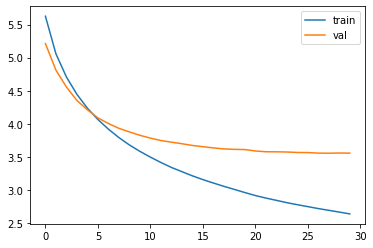

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

train loss : 2.6 / val loss : 3.5560 으로 그렇게 성능이 뛰어나지는 않지만,  
그래프를 확인해본결과 안정적으로 수렴되었음을 확인할 수 있었다.
***
### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [33]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [34]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [35]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_maxlen, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [36]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_maxlen-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [37]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [38]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_maxlen)))
    print("\n")

원문 : first ever video posted video sharing platform youtube featured co founder karim zoo talking elephants cool thing guys really really really long cool pretty much say says karim second video notably youtube founded february 
실제 요약 : youtube st video had co founder talking about elephants 
예측 요약 :  video users react to youtube park in new york


원문 : france year old forward kylian mbapp donate entire fifa world cup earnings including match fees bonus charity mbapp earning lakh per match given bonus nearly crore france win world cup mbapp saturday helped france reach quarters scoring two goals argentina 
실제 요약 : yr old mbapp to donate his entire fifa world cup salary 
예측 요약 :  french france wc final wc winning player to pay crore


원문 : virgin group founder richard branson admitted little bit jealous spacex falcon heavy rocket launch took place earlier month branson highlighted elon musk achieved launch extraordinary added disappointed spaceflight company virgin galactic space next m

예측 요약 :  yr old girl loses yr old for refusing to write her


원문 : houthi rebels recently fired ballistic missile towards saudi arabia said willing offer political asylum yemen saudi princes want flee oppression persecution according reports comes saudi princes four current ministers tens former ministers arrested kingdom anti corruption probe 
실제 요약 : offer saudi political asylum in yemen 
예측 요약 :  us air force missile to saudi arabia for yemen


원문 : pakistan needs restrict activities terror groups lashkar taiba jaish mohammed country tell world set house order pakistan foreign minister khawaja asif said comes five brics nations issued declaration slamming pakistan based terror groups including let jem first time 
실제 요약 : pakistan needs to restrict terror activities pak minister 
예측 요약 :  pakistan terror groups not terror groups list terror groups pak


원문 : mercedes benz india launched powerful version class new mercedes never explosive mix performance intelligence powered twin turb

예측 요약 :  infosys cfo slams trump over security


원문 : australia posthumously honoured peter sole white sprinter standing solidarity podium silent black power salute civil rights protest african american athletes mexico olympics aussie sprinter supported protest us smith john carlos wearing human rights badge leading frozen future olympics selection 
실제 요약 : aus honours white athlete involved in black power salute 
예측 요약 :  australia australia champ gay champ to be banned by white


원문 : like humans possess ability pass information across generations behavioural discovered study done gps devices known ability find home long distances findings showed birds improvised routes learned older generations showing human like collective intelligence cumulative culture 
실제 요약 : can pass knowledge across generations study 
예측 요약 :  human trafficking cases in bhu study


원문 : year old died four others sustained minor injuries van carrying kg ganesh idol ran people idol immersion procession bengalur

추상적 요약을 통해 생성한 요약문을 실제 요약문과 비교해보았다.  
재미있게도 유사한 부분도 있었지만 아직 생각보다 부족한 부분이 많다는 것을 느낀다.
***
### Step 5. Summa을 이용해서 추출적 요약해보기

In [78]:
# Summa를 위한 라이브러리 적용
import requests
from summa.summarizer import summarize

In [79]:
Summa_data = pd.read_csv(data_path, encoding='iso-8859-1')
Summa_data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [87]:
for i in range(50, 100):
    print("원문 :", Summa_data['text'][i])
    print("실제 요약 :", Summa_data['headlines'][i])
    print("예측 요약 :", summarize(Summa_data['text'][i], ratio=0.4))
    print("\n")


원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight

**추상적(Abstractive) 요약결과**  
원문 : security researchers annual hacking conference germany said successfully defeated biometric authentication creating fake hand wax researchers took around photos hand using camera removing infrared sensor better highlight veins authentication system hackers jan julian   
실제 요약 : hackers make fake wax hand fool authentication system   
예측 요약 :  hacked to be made by seconds  

**=> 새로운 문장을 생성하여 때로는 이전의 요약보다 나은 요약을 만들기도 하지만, 아직 학습량이 부족하여 매끄럽고 자연스럽게 만들지 못한다.**  
 
***
**추출적(Extractive) 요약결과**  
원문 : BJP President Amit Shah on Wednesday took a dig at the Opposition's proposed grand alliance saying if the "mahagathbandhan comes to power, each opposition leader will be a Prime Minister every day of the week". He added, "[The] country will go on...holiday on Sunday". He said the Opposition is thinking about leading the country but does not have a leader.  
실제 요약 : Grand alliance, if wins, will see a new PM every day: Shah  
예측 요약 : He said the Opposition is thinking about leading the country but does not have a leader.  

**=> 위의 추상적 요약보다는 문법적으로 좀더 낫다고 판단된다. 하지만 추상적요약의 성장 가능성이 더 높다고 판단된다.**
***
### 회고록
이번노드는 늘어진 문장을 요약하는 방법들에 대해서 배웠다.  
확실히 CV노드보다 자연어처리 노드가 좀더 친근하게 다가온다.  
생각보다 학습모델을 구현하는데에 어려움이 있었지만  
그래도 CV노드를 진행할 때보다는 마음이 편한했다.  
앞으로의 노드들에서도 자연어에 대한 부분을 좀더 습득하게 되기를 바란다.